#  Clean Labels
Clean each label file individually
- Reads dwh tables from `/storage/groups/ml01/datasets/raw/2018_LMUAugenklinik_niklas.koehler/dwh_tables`
- Writes cleaned dwh tables to `/storage/groups/ml01/datasets/projects/20181610_eyeclinic_niklas.koehler/dwh_tables_cleaned`

In [1]:
import os
import pandas as pd
from ipywidgets import interact, fixed
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import re
from glob import glob
from datetime import datetime
from pydicom import read_file
from tqdm import tqdm
import imageio

import sys
sys.path.append('../../DeepRT/thickness_map_calculation')
import dicom_table as dt

In [2]:
RAW_DIR = "/storage/groups/ml01/datasets/raw/2018_LMUAugenklinik_niklas.koehler"
DATA_DIR = "/storage/groups/ml01/datasets/projects/20181610_eyeclinic_niklas.koehler"

raw_data_dir = os.path.join(RAW_DIR, 'joint_export/dwh_tables')
clean_data_dir = os.path.join(DATA_DIR, 'joint_export/dwh_tables_cleaned')

## Clean visus labels

In [37]:
def to_logMAR(va):
    # converts decimal va values to logMAR scale
    try:
        va = float(va)
        if va == 0:
            return np.inf
        else:
            return np.log10(1/va)
    except ValueError:
        return np.nan

def get_visual_acuity(group):
    # parses items in ordered group. If first value cannot be parsed, moves on to next value
    for i, raw in enumerate(list(group.visual_acuity_raw)):
        va = parse_visual_acuity(raw)
        if va is not None:
            res = list(group.iloc[i])
            res.append(va)
            return res
    return None

def parse_visual_acuity(raw):
    if pd.isna(raw):
        return None
    
    # match range of two comma/dot separated values
    m = re.match(r'.*(\d+)[,\.](\d+)[ -]+(\d+)[,\.](\d+).*$', raw)
    if m:
        return np.mean([float('{}.{}'.format(m.group(1), m.group(2))), 
                       float('{}.{}'.format(m.group(3), m.group(4)))])
    
    # match comma/dot separated value, allowing comma, space, "sc" as first character
    m = re.match(r'[ ,\.a-zA-Z]*([\do]+)[\., ]+(\d+).*$', raw)
    if m:
        return float('{}.{}'.format(m.group(1).replace('o', '0'), m.group(2)))
    
    # match two integer values separated with /, allowing space, "sc, HT" as first character
    m = re.match(r'[ a-zA-Z:]*(\d+)[ /]+(\d+)[a-zA-Z \.]*$', raw)
    if m:
        return int(m.group(1))/float(m.group(2))
        
    # match HBW
    if re.match(r'.*[hH]\.*[bB]\.*[wW]*\.*', raw):
        return 'HBW'
    # match FZ
    elif re.match(r'[fF]\.*[zZ]\.*', raw):
        return 'FZ'
    # match Lilo
    elif re.match(r'li(cht){0,1}(lo(kal){0,1}){0,1}', raw, flags=re.IGNORECASE):
        return 'LILO'
    # match Nulla LUX
    elif re.match(r'(n[ulla]*|kein)\.* *l([ux\.]*|[icht]*)', raw, flags=re.IGNORECASE):        
        return 'NL'
    # match FIX
    elif re.match(r'fix.*', raw, flags=re.IGNORECASE):
        return 'FIX'
    # match LUX
    elif re.match(r'.*lux.*', raw, flags=re.IGNORECASE):  
        return 'LUX'
    
    else:
        return "other"

In [38]:
visus_labels = pd.read_csv(os.path.join(raw_data_dir, 'visus_labels.csv'), index_col=0)
print('Starting with {} measurements'.format(len(visus_labels)))

# rename columns
visus_labels.rename(columns={'AUGE': 'laterality_raw', 'MEASUREMENT_DATE':'study_date', 'PATNR':'patient_id',
                            'visual_acuity_VISUS': 'visual_acuity_raw', 'ORIGIN_TYPE': 'visual_acuity_origin'}, 
                    inplace=True)

# format columns 
visus_labels.study_date = pd.to_datetime(visus_labels.study_date)

# imputer origin value, ok?
visus_labels.visual_acuity_origin.fillna("OR", inplace=True)

visus_labels.visual_acuity_origin = pd.Categorical(visus_labels.visual_acuity_origin,
                                                   ['SR', 'OR', 'CC', 'STP', 'SC'])

# remove rows with missing study dates
visus_labels = visus_labels[~ visus_labels.study_date.isna()]

# duplicate entries for laterality=='B'
visus_labels['laterality'] = visus_labels['laterality_raw']
visus_labels.loc[visus_labels['laterality_raw'] == 'B', 'laterality'] = 'L'
visus_R = visus_labels.loc[visus_labels['laterality_raw'] == 'B'].copy().assign(laterality='R')
visus_labels = visus_labels.append(visus_R, ignore_index=True)

# merge new values
visus_labels.visual_acuity_raw.fillna(visus_labels.MEASUREMENT_VALUE, inplace=True)
visus_labels.visual_acuity_raw.fillna(visus_labels.CALCULATED_VALUE, inplace=True)

# convert integers strings to float strings
visus_labels.loc[:, "visual_acuity_raw"] = visus_labels.visual_acuity_raw.replace({'1':'1.0'})
visus_labels.loc[:, "visual_acuity_raw"] = visus_labels.visual_acuity_raw.replace({'0':'0.0'})

# get rid of exact duplicates
num_raw = visus_labels.shape[0]
visus_labels = visus_labels.drop_duplicates(keep='first')
num_raw_nodup = visus_labels.shape[0]
print('Dropped {} exact duplicates'.format(num_raw-num_raw_nodup))

# count duplicate measurements per time point
num_dups = sum(visus_labels.duplicated(['study_date', 'patient_id', 'laterality']))
print('Resolving {} duplicate measurements per time point'.format(num_dups))

# group by time point measurements
groups = visus_labels.groupby(['patient_id', 'laterality', 'study_date'])
keys = groups.groups.keys()

/home/icb/olle.holmberg/anaconda3/envs/tf2_super/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (5,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/icb/olle.holmberg/anaconda3/envs/tf2_super/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Starting with 1212908 measurements
Dropped 3 exact duplicates
Resolving 483503 duplicate measurements per time point


In [39]:
sum(visus_labels.CALCULATED_VALUE.isna()), sum(visus_labels.LOGMAR_VALUE.isna()), sum(visus_labels.MEASUREMENT_VALUE.isna()) 

(820688, 820688, 820004)

### Save away all measurements to use for imputation later

In [40]:
all_measurements = visus_labels[['patient_id', 'laterality', 'study_date', 
              "CALCULATED_VALUE", "LOGMAR_VALUE", "MEASUREMENT_VALUE"]]

In [41]:
visus_labels.drop(columns=["CALCULATED_VALUE", "LOGMAR_VALUE", "MEASUREMENT_VALUE"], inplace=True)

## Parse all visual acuity values into rows

In [42]:
print('Before visual acuity parsing: {} unique time/patient/laterality measurements'.format(len(keys)))

rows = []
for key in tqdm(keys):
    # sort values to ensure that correct VA value is taken 
    grp = groups.get_group(key).sort_values('visual_acuity_origin')
    res = get_visual_acuity(grp)
    if res is not None:
        rows.append(res)

  0%|          | 0/730081 [00:00<?, ?it/s]

Before visual acuity parsing: 730081 unique time/patient/laterality measurements


100%|██████████| 730081/730081 [30:22<00:00, 400.62it/s] 


In [43]:
visus_labels_clean = pd.DataFrame.from_records(rows, columns=['laterality_raw', 'study_date', 
                                                              'visual_acuity_origin',
                                                              'patient_id', 'visual_acuity_raw', 'laterality', 
                                                              'visual_acuity'])

print('Number of cleaned measurements {}'.format(visus_labels_clean.shape[0]))

Number of cleaned measurements 730080


In [44]:
# add logMAR_raw column (unmapped, no string values)
visus_labels_clean['logMAR_raw'] = visus_labels_clean.visual_acuity.apply(to_logMAR)

In [45]:
va_num = visus_labels_clean['logMAR_raw']
va_str = visus_labels_clean['visual_acuity_raw']

# print frequency of logMAR values and strings
nums, bins = np.histogram(va_num, bins=np.concatenate([[-np.inf], np.arange(-0.4,2.1,0.2), [10, np.inf]]))
for i, num in enumerate(nums[:-1]):
    print('[{:.1f},{:.1f}):\t{}'.format(bins[i], bins[i+1], nums[i]))
print('[{:.1f},{:.1f}]:\t{}'.format(bins[-2], bins[-1], nums[-1]))

for s in ['FZ', 'HBW', 'FIX', 'LILO', 'LUX', 'NL']:
    print('{}:\t\t{}'.format(s, sum(va_str==s)))

[-inf,-0.4):	302
[-0.4,-0.2):	898
[-0.2,0.0):	15657
[0.0,0.2):	301105
[0.2,0.4):	206860
[0.4,0.6):	32617
[0.6,0.8):	46829
[0.8,1.0):	6442
[1.0,1.2):	31409
[1.2,1.4):	13551
[1.4,1.6):	4822
[1.6,1.8):	1900
[1.8,2.0):	233
[2.0,10.0):	32
[10.0,inf]:	113
FZ:		7377
HBW:		20001
FIX:		1084
LILO:		7
LUX:		2735
NL:		3630


map logMAR and string values: (using values from https://michaelbach.de/sci/acuity.html)
- logMAR < -0.3 gets mapped to -0.3
- logMAR == inf gets mapped to value for NL (va 0 means blind!)
- OLD: logMAR > 2.0 gets mapped to 2.0. This is not done anymore, values stay as is!
- FZ (count fingers) gets mapped to 1.9
- HBW gets mapped to 2.3 
- FIX/LILO gets mapped to 2.6
- LUX gets mapped to 2.8
- NL gets mapped to 3.0

In [46]:
visus_labels_clean['logMAR'] = visus_labels_clean.logMAR_raw
# mapping logMAR values
visus_labels_clean.loc[visus_labels_clean.logMAR_raw<-0.3, 'logMAR'] = -0.3
#visus_labels_clean.loc[visus_labels_clean.logMAR_raw>2.0, 'logMAR'] = 2.0
visus_labels_clean.loc[visus_labels_clean.logMAR_raw==np.inf, 'logMAR'] = 3.0
# string values
visus_labels_clean.loc[visus_labels_clean.visual_acuity=='FZ', 'logMAR'] = 1.9
visus_labels_clean.loc[visus_labels_clean.visual_acuity=='HBW', 'logMAR'] = 2.3
visus_labels_clean.loc[visus_labels_clean.visual_acuity=='FIX', 'logMAR'] = 2.6
visus_labels_clean.loc[visus_labels_clean.visual_acuity=='LILO', 'logMAR'] = 2.6
visus_labels_clean.loc[visus_labels_clean.visual_acuity=='LUX', 'logMAR'] = 2.8
visus_labels_clean.loc[visus_labels_clean.visual_acuity=='NL', 'logMAR'] = 3.0

## Match other measurements to potential CALCULATED Values

As only na values were replaced by "CALCULATED_VALUE" or "LOGMAR_VALUE" or "MEASUREMENT_VALUE". 

Some none na values were not successfully parsed and transformed to logMAR, thus the below code
replaces those we precomputed logMAR provided from the last export.


In [68]:
all_meas_columns = ["study_date", "patient_id", "laterality", "LOGMAR_VALUE"]
visus_labels_clean_ = pd.merge(visus_labels_clean, all_measurements[all_meas_columns].drop_duplicates(), 
                                 on=["study_date", "patient_id", "laterality"], how="left").drop_duplicates()

visus_labels_clean_.loc[:, "logMAR"] = visus_labels_clean_.logMAR.fillna(visus_labels_clean_.LOGMAR_VALUE)

visus_labels_clean_ = visus_labels_clean_[~visus_labels_clean_.logMAR.isna()]

In [49]:
## Integrate supplement table

In [92]:
# load supplement table
manual_va_check = pd.read_excel(os.path.join(raw_data_dir, "supplement_tables/visual_ac_check.xlsx"), 
                                engine='openpyxl')

# filter for cases with first va and first OCT less than 2 months apart
delta = manual_va_check.first_oct_date_registrered_wo_visual_acuity - manual_va_check.date_va_first_injection

manual_va_check = manual_va_check[np.abs(delta).dt.days < 60]

# load supplement table
manual_va_check = pd.read_excel(os.path.join(raw_data_dir, "supplement_tables/visual_ac_check.xlsx"), 
                                engine='openpyxl')


# format into visus table clean format
manual_va_check_f = manual_va_check[["patient_id", "laterality", "first_oct_date_registrered_wo_visual_acuity", "va_first_injection"]]
manual_va_check_f = manual_va_check_f.dropna()

manual_va_check_f.loc[:, "laterality_raw"] = manual_va_check_f.laterality
manual_va_check_f.loc[:, "visual_acuity_origin"] = "nan"

manual_va_check_f = manual_va_check_f.rename(columns={"first_oct_date_registrered_wo_visual_acuity": "study_date", 
                                                      "va_first_injection": "visual_acuity_raw"})

manual_va_check_f.loc[:, "visual_acuity"] = manual_va_check_f.visual_acuity_raw
manual_va_check_f.loc[:, "laterality_raw"] = manual_va_check_f.laterality

# add logMAR_raw column (unmapped, no string values)
manual_va_check_f.loc[:, 'logMAR_raw'] = manual_va_check_f.visual_acuity.apply(to_logMAR)
manual_va_check_f.loc[:, "logMAR"] = manual_va_check_f.logMAR_raw

manual_va_check_f.loc[:, "patient_id"] = manual_va_check_f.patient_id.astype(int)


# append to main table
#visus_labels_clean_ = visus_labels_clean_.drop(["LOGMAR_VALUE"], axis=1)
visus_labels_clean_ = pd.concat([visus_labels_clean_, manual_va_check_f])

# drop duplicates
visus_labels_clean_ = visus_labels_clean_.drop_duplicates(subset=["patient_id", "laterality", "study_date"])

In [64]:
# print frequency of logMAR values and strings
nums, bins = np.histogram(visus_labels_clean_.logMAR, bins=np.concatenate([[-np.inf], np.arange(-0.401,3.1,0.2), [np.inf]]))
for i, num in enumerate(nums[:-1]):
    print('[{:.3f},{:.3f}):\t{}'.format(bins[i], bins[i+1], nums[i]))
print('[{:.3f},{:.3f}]:\t{}'.format(bins[-2], bins[-1], nums[-1]))

[-inf,-0.401):	0
[-0.401,-0.201):	1200
[-0.201,-0.001):	16813
[-0.001,0.199):	301125
[0.199,0.399):	206915
[0.399,0.599):	32656
[0.599,0.799):	47065
[0.799,0.999):	6586
[0.999,1.199):	36750
[1.199,1.399):	17643
[1.399,1.599):	6795
[1.599,1.799):	7603
[1.799,1.999):	7888
[1.999,2.199):	174
[2.199,2.399):	22148
[2.399,2.599):	4
[2.599,2.799):	4158
[2.799,2.999):	5181
[2.999,inf]:	5985


In [94]:
# save cleaned table
visus_labels_clean_.to_csv(os.path.join(clean_data_dir, 'visus_labels_clean.csv'))

## Diagnoses

In [121]:
diagnosis = pd.read_csv(os.path.join(raw_data_dir, 'diagnosis.csv'), index_col=0)
print('Starting with {} measurements'.format(len(diagnosis)))

# rename columns
diagnosis.rename(columns={'LOK': 'laterality_raw', 'DAT':'study_date', 'PATNR':'patient_id', 'DKAT':'DKAT', 'DKEY':'diagnosis'}, inplace=True)

# format columns 
diagnosis.study_date = pd.to_datetime(diagnosis.study_date)
diagnosis.diagnosis = diagnosis.diagnosis.astype('str')

# remove non-eye related diagnoses
diagnosis['category'] = diagnosis.diagnosis.apply(lambda x: x[0])
diagnosis = diagnosis[diagnosis.category == 'H']  # TODO need to include 'E' as well for diabetic retinopathy
print('Starting with {} diagnoses of eye diseases'.format(len(diagnosis)))

# removing duplicates
diagnosis = diagnosis.drop_duplicates()
print('After removing duplicates: {} diagnoses'.format(len(diagnosis)))

# todo drop nan laterality diagnoses? 
# put duplicate diagnoses in list

/home/icb/olle.holmberg/anaconda3/envs/tf2_super/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Starting with 2041980 measurements
Starting with 1036829 diagnoses of eye diseases
After removing duplicates: 918283 diagnoses


In [122]:
# load descriptions of diagnoses
diagnosis_code = pd.read_csv(os.path.join(clean_data_dir, 'icd10cm_order_2018.txt'), sep='\t', header=None)

codes = []
desc = []
for i in range(len(diagnosis_code)):
    code = diagnosis_code[0][i]
    codes.append(code[6:14].strip())
    desc.append(code[16:77].strip())
    
diagnosis_code['diagnosis'] = codes
diagnosis_code['description'] = desc
diagnosis_code = diagnosis_code[['diagnosis', 'description']]   

In [123]:
# statistics
diag = list(diagnosis['diagnosis'])
diag_cl = []
for d in diag:
    if len(re.findall(r'H\d\d\.\d', d)) > 0:
        diag_cl.append(d)
        
unique, counts = np.unique(diag_cl, return_counts=True)

# sort by frequency
unique_sorted = [x for _,x in sorted(zip(counts,unique), reverse=True)]
counts_sorted = sorted(counts, reverse=True)

In [124]:
for i in range(20):
    desc = diagnosis_code[diagnosis_code.diagnosis==unique_sorted[i].replace('.','')].description
    try:
        desc = desc.iloc[0]
    except IndexError:
        desc = ''
    print('{}: {}: {}'.format(counts_sorted[i], unique_sorted[i], desc))
    

91331: H35.3: Degeneration of macula and posterior pole
31429: H33.0: Retinal detachment with retinal break
29721: H25.8: Other age-related cataract
28533: H40.1: Open-angle glaucoma
27715: H35.8: Other specified retinal disorders
24336: H52.1: Myopia
22980: H25.1: Age-related nuclear cataract
19741: H34.8: Other retinal vascular occlusions
19012: H52.0: Hypermetropia
16202: H16.0: Corneal ulcer
16032: H00.0: Hordeolum (externum) (internum) of eyelid
15960: H26.9: Unspecified cataract
15119: H52.2: Astigmatism
14807: H50.0: Esotropia
13115: H47.2: Optic atrophy
12331: H16.1: Other and unsp superficial keratitis without conjunctivitis
11716: H36.0: 
11656: H04.1: Other disorders of lacrimal gland
11631: H43.1: Vitreous hemorrhage
10970: H10.0: Mucopurulent conjunctivitis


(0.0, 200.0)

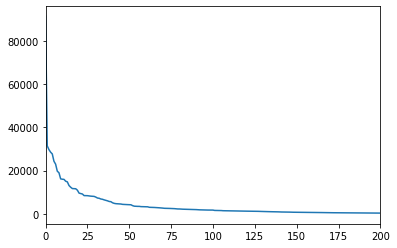

In [125]:
plt.plot(range(len(counts_sorted)), [int(u) for u in counts_sorted])
plt.xlim(0,200)

In [126]:
# save cleaned table
diagnosis.to_csv(os.path.join(clean_data_dir, 'diagnosis_clean.csv'))

## Other procedures

In [128]:
procedures = pd.read_csv(os.path.join(raw_data_dir, 'prozeduren.csv'), index_col=0)

# rename columns
procedures.rename(columns={'LOK': 'laterality_raw', 'DAT':'study_date', 'PATNR':'patient_id'}, inplace=True)
# format columns 
procedures.study_date = pd.to_datetime(procedures.study_date)

# duplicate entries for laterality=='B'
procedures['laterality_raw'].fillna('B', inplace=True)
procedures['laterality'] = procedures['laterality_raw']
procedures.loc[procedures['laterality_raw'] == 'B', 'laterality'] = 'L'
procedures_R = procedures.loc[procedures['laterality_raw'] == 'B'].copy().assign(laterality='R')
procedures = procedures.append(procedures_R, ignore_index=True)

# get rid of exact duplicates
num_raw = procedures.shape[0]
procedures = procedures.drop_duplicates(keep='first')
num_raw_nodup = procedures.shape[0]
print('Dropped {} exact duplicates'.format(num_raw-num_raw_nodup))

# take care of duplicate measurements per time point
num_dups = sum(procedures.duplicated(['study_date', 'patient_id', 'laterality']))
print('Resolving {} duplicate measurements per time point'.format(num_dups))

# remove everything not in chapter 5 08-16 (surgeries of the eye)
procedures_filtered = procedures[procedures.ICPML.apply(lambda x: x[:4] in ['5-08','5-09','5-10','5-11','5-12','5-13','5-14','5-15','5-16'])]
# reduce code to 3 decimals
procedures_filtered.ICPML = procedures_filtered.loc[:,'ICPML'].apply(lambda x: x[:5])
print('Number of filtered procedures {}'.format(len(procedures_filtered)))

/home/icb/olle.holmberg/anaconda3/envs/tf2_super/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Dropped 143638 exact duplicates
Resolving 687429 duplicate measurements per time point
Number of filtered procedures 315216


/home/icb/olle.holmberg/.local/lib/python3.6/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


5-156 77771
5-154 48992
5-144 38998
5-158 32460
5-159 18176
5-155 12621
5-091 6929
5-10K 6316
5-142 5585
5-139 5098
5-152 4619
5-096 3526
5-093 2939
5-132 2934
5-094 2905
5-097 2889
5-125 2494
5-131 2417
5-133 2158
5-129 2051


(0.0, 50.0)

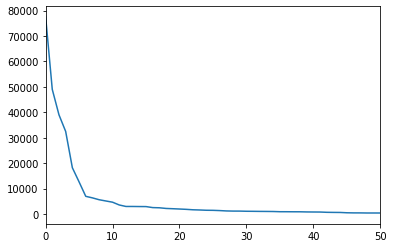

In [129]:
# list most common procedures
unique, counts = np.unique(list(procedures_filtered.ICPML), return_counts=True)
unqiue = [u for _,u in sorted(zip(counts, unique), reverse=True)]
counts = sorted(counts, reverse=True)

for i in range(20):
    print(unqiue[i], counts[i])
    
plt.plot(range(len(counts)), [int(u) for u in counts])
plt.xlim(0,50)

codes with highest occurrence:
- 5-984 nicht relevant
- 5-156.9 - Injektionen
- 5-154 - Netzhautfixierung
- 5-144 - Extrakapsuläre Extraktion der Linse
- 5-158 - Vitrektomie
- 5-985 - Lasertechnik, nicht relevant
- 5-159 - Vitrektomie
- 5-155 - Destruktion von erkranktem Gewebe an Retina und Choroidea
- 5-010 - nicht relevant
- 5-091 - Exzision und Destruktion von (erkranktem) Gewebe des Augenlides, nicht relevant?

In [130]:
# save procedures - not quite clean
procedures_filtered.to_csv(os.path.join(clean_data_dir, 'procedures_clean.csv'))
print('Saved {} procedures'.format(len(procedures_filtered)))

Saved 315216 procedures


In [131]:
procedures_filtered.head()

,study_date,ICPMK,ICPML,laterality_raw,patient_id,laterality
1,2014-05-21,PC,5-091,L,17,L
4,2018-01-08,PG,5-156,R,18,R
5,2018-02-07,PG,5-156,R,18,R
6,2018-06-21,PG,5-156,R,18,R
7,2019-03-13,PH,5-156,R,18,R


## Get OCT and fundus maps
### OCTs

In [11]:
oct_meta_information = pd.read_csv(os.path.join(RAW_DIR,"joint_export", 'oct_meta_information.csv'))

columns_oi = ["PATNR", "laterality", "study_date", "oct_path"]
octs = oct_meta_information[columns_oi]

# rename columns
octs = octs.rename(columns={"PATNR":"patient_id"})

# add non existing fundus path
octs["fundus_path"] = None

print("Number of oct paths before dropping duplicates: ", octs.shape[0])

# drop any duplicates
octs_no_dups = octs.drop_duplicates(subset=["patient_id", "laterality", "study_date"])

print("Number of oct paths after dropping duplicates: ", octs_no_dups.shape[0])

Number of oct paths before dropping duplicates:  326657
Number of oct paths after dropping duplicates:  212091


In [7]:
# save cleaned table
octs.to_csv(os.path.join(clean_data_dir, 'octs_fundus_with_dups.csv'))

#### duplicate OCTs
- some are unreadable, or have the wrong format
- of the duplicates, often one will be of the optical nerve and the other of the macula

In [20]:
octs_nona = octs.dropna(subset=['patient_id', 'laterality', 'study_date'])

idx_cols = ['patient_id', 'laterality', 'study_date']
print('Have {} duplicated octs'.format(sum(octs_nona.duplicated(idx_cols))))

dup_octs = octs_nona[octs_nona.duplicated(idx_cols, keep=False)]
octs_grouped = dup_octs.groupby(idx_cols)
oct_keys = octs_grouped.groups.keys()

octs_nona = octs_nona.sort_values("study_date")

Have 114566 duplicated octs


In [9]:
nodup_octs = octs_nona.drop_duplicates(idx_cols, keep=False)
print('Have {} non-duplicated octs'.format(len(nodup_octs)))

Have 118861 non-duplicated octs


### deal with duplicate octs
... by throwing them out
- in the future, might need to come back to this and do sth more advanced

In [10]:
# save cleaned table
octs_no_dups.to_csv(os.path.join(clean_data_dir, 'octs_fundus_no_dups.csv'))